In [1]:
import statsmodels.formula.api as sm

In [3]:
ctrl = pd.read_pickle('./data/wrf_hw_ctrl_diversion_sm_rr.pcl')
ctrl.reset_index(inplace=True)
pgw = pd.read_pickle('./data/wrf_hw_pgw_diversion_sm_rr.pcl')
vic = pd.read_hdf('../Budyko_vic/WSC_HUC8_budyko.hdf','df')

In [4]:
vic.columns = ['idx','PET','huc8','precip','Q','snowmelt','ET','wyear','rain','wflux','Q_P','ET_P','DEMelev']

In [5]:
diversions = pd.read_pickle('./data/diversions.pcl')

In [114]:
diversions

,diversion,diversionname,fromname,huc8from,huc8to,toname
0,10180001:10190007,North Platte Headwaters : Cache La Poudre,North Platte Headwaters,10180001,10190007,Cache La Poudre
1,10180010:10190007,Upper Laramie : Cache La Poudre,Upper Laramie,10180010,10190007,Cache La Poudre
2,14010001:10190004,Colorado Headwaters : Clear,Colorado Headwaters,14010001,10190004,Clear
3,14010001:10190005,Colorado Headwaters : St. Vrain,Colorado Headwaters,14010001,10190005,St. Vrain
4,14010001:10190006,Colorado Headwaters : Big Thompson,Colorado Headwaters,14010001,10190006,Big Thompson
5,14010001:10190007,Colorado Headwaters : Cache La Poudre,Colorado Headwaters,14010001,10190007,Cache La Poudre
6,14010002:10190001,Blue : South Platte Headwaters,Blue,14010002,10190001,South Platte Headwaters
7,14010002:10190002,Blue : Upper South Platte,Blue,14010002,10190002,Upper South Platte
8,14010002:10190004,Blue : Clear,Blue,14010002,10190004,Clear
9,14010003:11020001,Eagle : Arkansas Headwaters,Eagle,14010003,11020001,Arkansas Headwaters


In [51]:
def compute_sensitivity(df,sim):
    value = []
    parameter = []
    watershed = []

    for huc8 in df.huc8.unique():
        mod = sm.ols('Q_P ~ wflux + 1',df.loc[df.huc8==huc8]).fit()
        ci = mod.conf_int()
        
        vals = [mod.rsquared,mod.f_pvalue,mod.params['wflux'],ci[0]['wflux'],ci[1]['wflux']]
        params = ['r2','pval','slope','min_slp','max_slp']
        
        [value.append(val) for val in vals] # append values to list
        [parameter.append(param) for param in params] # append parameters to list
        
        watershed.extend(list(np.repeat(int(huc8),len(vals))))
        
    out = pd.DataFrame({'value':value,'parameter':parameter,'huc8':watershed})
    out['simulation'] = sim
    
    return out

In [52]:
out = pd.DataFrame(columns=['value','huc8','parameter','simulation'])

In [53]:
out = out.append(compute_sensitivity(ctrl,'wrf_ctrl'))
out = out.append(compute_sensitivity(pgw,'wrf_pgw'))
out = out.append(compute_sensitivity(vic,'vic'))

In [54]:
out.head()

,huc8,parameter,simulation,value
0,10180001,r2,wrf_ctrl,0.616852
1,10180001,pval,wrf_ctrl,0.020902
2,10180001,slope,wrf_ctrl,115.731713
3,10180001,min_slp,wrf_ctrl,24.617109
4,10180001,max_slp,wrf_ctrl,206.846317


In [150]:
def compute_diversion_ratios(out):
    divs = list(diversions.diversion)
    parameters = []
    values = []
    diversion = []
    simulations = []
    
    params = ['ratio','min_ratio','max_ratio','to_slp','from_slp','to_slp_min','to_slp_max',
              'from_slp_min','from_slp_max']
    m = len(params)
    
    for div in divs:
        to = int(div.split(':')[1])
        frm = int(div.split(':')[0])
        df_to = out.loc[out.huc8 == to]
        df_from = out.loc[out.huc8 == frm]
        
        for sim in ['vic','wrf_ctrl','wrf_pgw']:
            
            tmp_to = df_to.loc[df_to.simulation == sim]
            tmp_from = df_from.loc[df_from.simulation == sim]
            
            to_slp = tmp_to.loc[tmp_to.parameter == 'slope','value'].as_matrix()[0]
            from_slp = tmp_from.loc[tmp_from.parameter == 'slope','value'].as_matrix()[0]
            to_slp_min = tmp_to.loc[tmp_to.parameter == 'min_slp','value'].as_matrix()[0]
            to_slp_max = tmp_to.loc[tmp_to.parameter == 'max_slp','value'].as_matrix()[0]
            from_slp_min = tmp_from.loc[tmp_from.parameter == 'min_slp','value'].as_matrix()[0]
            from_slp_max = tmp_from.loc[tmp_from.parameter == 'max_slp','value'].as_matrix()[0]
            
            if (sim == 'wrf_ctrl') | (sim == 'wrf_pgw'):
                to_slp /= 1000.
                from_slp /= 1000.
                to_slp_min /= 1000.
                to_slp_max /= 1000.
                from_slp_min /= 1000.
                from_slp_max /= 1000.
            
            ratio = from_slp/to_slp
            min_ratio = from_slp_min/to_slp_min
            max_ratio = from_slp_max/to_slp_max
        
            vals = [ratio,min_ratio,max_ratio,to_slp,from_slp,to_slp_min,to_slp_max,
              from_slp_min,from_slp_max]
            
            [values.append(val) for val in vals]
            [parameters.append(param) for param in params]
            
            diversion.extend(list(np.repeat(div,m)))
            simulations.extend(list(np.repeat(sim,m)))
            
            
    return pd.DataFrame({'diversion':diversion,'value':values,'parameter':parameters,'simulation':simulations})

In [151]:
df = compute_diversion_ratios(out)

In [152]:
def get_diversion_name(div):
    return str(diversions.loc[diversions.diversion==div,'diversionname'].as_matrix()[0])

In [153]:
df['diversionname'] = df.diversion.map(get_diversion_name)

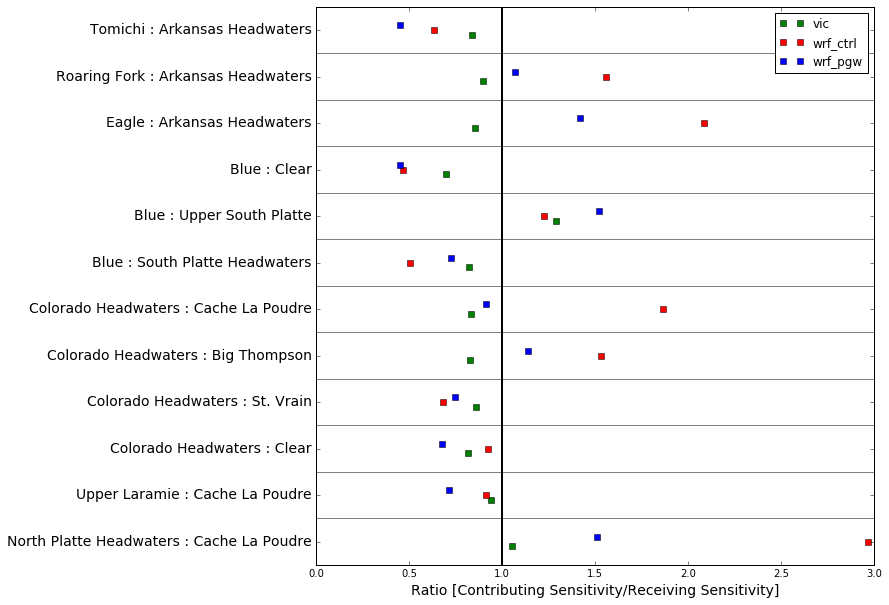

In [154]:
fig = plt.figure(figsize=(10,10))
ct = 1
simulations = ['vic','wrf_ctrl','wrf_pgw']
colors = ['g','r','b']
spacings = [-0.2,0,0.2]
sp2 = 1
ax = fig.add_subplot(111)
for div in df.diversion.unique():
    for sim,space,color in zip(simulations,spacings,colors):
     
        x = df.loc[(df.diversion==div) & (df.simulation==sim) & (df.parameter =='ratio'),'value'].as_matrix()[0]
        y = ct + space
    
        p = ax.plot(x,y,'s',c=color)
    
    ax.axhline(ct+sp2,c='0.5')
    ax.axhline(ct-sp2,c='0.5')
    ct += 2
ax.set_yticks(np.arange(1,25,2))    
ax.set_yticklabels(df.diversionname.unique(),fontsize=14)
[ax.plot(100,100,'s',c=col,label=sim) for sim,col in zip(simulations,colors)]

plt.xlim(0,3)
plt.ylim(0,24)
ax.legend()
plt.xlabel('Ratio [Contributing Sensitivity/Receiving Sensitivity]', fontsize = 14)
ax.axvline(1,c='k',lw=2)

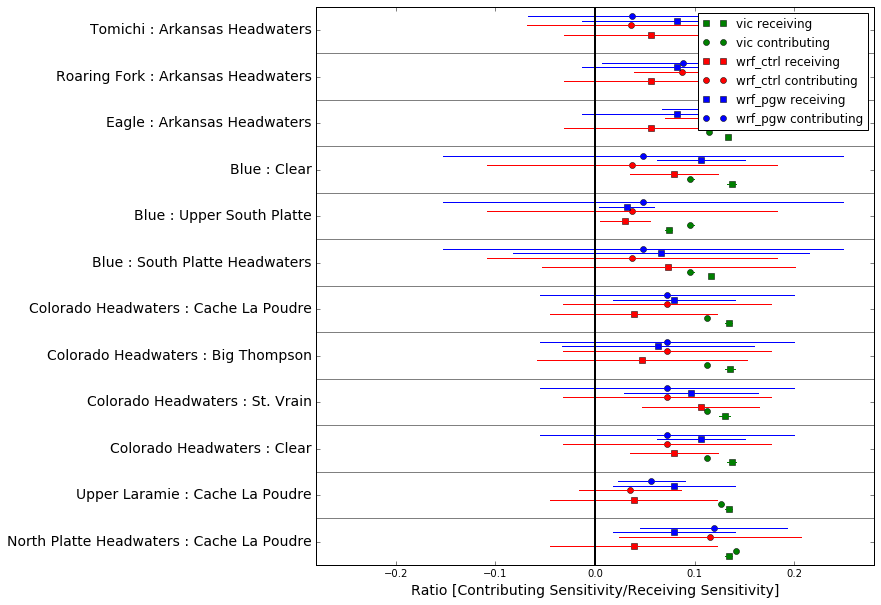

In [173]:
fig = plt.figure(figsize=(10,10))
ct = 1
simulations = ['vic','vic','wrf_ctrl','wrf_ctrl','wrf_pgw','wrf_pgw']
colors = ['g','g','r','r','b','b']
markers = ['s','o','s','o','s','o']
spacings = [-0.6,-0.4,-0.2,0.2,0.4,0.6]
variables1 = ['to_slp','from_slp','to_slp','from_slp','to_slp','from_slp'] # set variable order
variables2 = ['to_slp_min','from_slp_min','to_slp_min','from_slp_min','to_slp_min','from_slp_min']
variables3 = ['to_slp_max','from_slp_max','to_slp_max','from_slp_max','to_slp_max','from_slp_max']
sp2 = 1
ax = fig.add_subplot(111)
for div in df.diversion.unique():
    for sim,space,color,var1,var2,var3,marker in zip(simulations,spacings,colors,variables1,variables2,variables3,markers):
     
        x = df.loc[(df.diversion==div) & (df.simulation==sim) & (df.parameter ==var1),'value'].as_matrix()[0]
        xmin = df.loc[(df.diversion==div) & (df.simulation==sim) & (df.parameter ==var2),'value'].as_matrix()[0]
        xmax = df.loc[(df.diversion==div) & (df.simulation==sim) & (df.parameter ==var3),'value'].as_matrix()[0]
        y = ct + space
    
        ax.plot(x,y,marker,c=color)
        ax.plot([xmin,xmax],[y,y],c=color)
        
    ax.axhline(ct+sp2,c='0.5')
    ax.axhline(ct-sp2,color='0.5')
    ct += 2
ax.set_yticks(np.arange(1,25,2))    
ax.set_yticklabels(df.diversionname.unique(),fontsize=14)
simulations = ['vic receiving','vic contributing','wrf_ctrl receiving','wrf_ctrl contributing',
               'wrf_pgw receiving','wrf_pgw contributing']

[ax.plot(100,100,marker,c=col,label=sim) for sim,col,marker in zip(simulations,colors,markers)]
ax.legend()

plt.xlim(-0.28,0.28)
plt.ylim(0,24)
plt.xlabel('Ratio [Contributing Sensitivity/Receiving Sensitivity]', fontsize = 14)
ax.axvline(0,c='k',lw=2)